In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow as tf
import seaborn as sns

# Configurar el estilo de los gráficos
sns.set(style="ticks")

# Undestanding the Dataset

## Load Data

In [24]:
# Define paths
train_folder = "../../Dataset/Audios/Train/"
validation_folder = "../../Dataset/Audios/Validation/"
test_folder = "../../Dataset/Audios/Test/"

# List class folders
train_classes = os.listdir(train_folder)
validation_classes = os.listdir(validation_folder)
test_classes = os.listdir(test_folder)
classes = list(set(train_classes + validation_classes + test_classes))

# Display classes
print(f"Classes ({len(classes)}): {classes}")

# Check the distribution of samples per class
def check_class_distribution(folder):
    distribution = {cls: len(os.listdir(os.path.join(folder, cls))) for cls in os.listdir(folder)}
    return pd.DataFrame(distribution.items(), columns=["Class", "Count"])

train_dist = check_class_distribution(train_folder)
validation_dist = check_class_distribution(validation_folder)
test_dist = check_class_distribution(test_folder)

# Añadir una columna para identificar el conjunto de datos
train_dist['Dataset'] = 'Train'
validation_dist['Dataset'] = 'Validation'
test_dist['Dataset'] = 'Test'

# Combinar los DataFrames
combined_dist = pd.concat([train_dist, validation_dist, test_dist])

Classes (10): ['Golpe', 'Toque', 'Whistle', 'Breath1KHz', 'Batida', 'EmbarcacionLejana', 'EmbarcacionCercana', 'CLICK', 'BatidaClicksRapidaCascabel', 'BatidaClicks']


In [4]:
# Load CSVs
def load_and_calculate_duration(csv_path):
    df = pd.read_csv(csv_path)
    df['Duration'] = df['EndSecond'] - df['StartSecond'] + 1
    return df

train_csv = load_and_calculate_duration("../../Dataset/CSVs/TrainDataset.csv")
validation_csv = load_and_calculate_duration("../../Dataset/CSVs/ValidationDataset.csv")
test_csv = load_and_calculate_duration("../../Dataset/CSVs/TestDataset.csv")

# Añadir una columna para identificar el conjunto de datos
train_csv['Dataset'] = 'Train'
validation_csv['Dataset'] = 'Validation'
test_csv['Dataset'] = 'Test'

# Combinar los DataFrames
combined_csv = pd.concat([train_csv, validation_csv, test_csv])

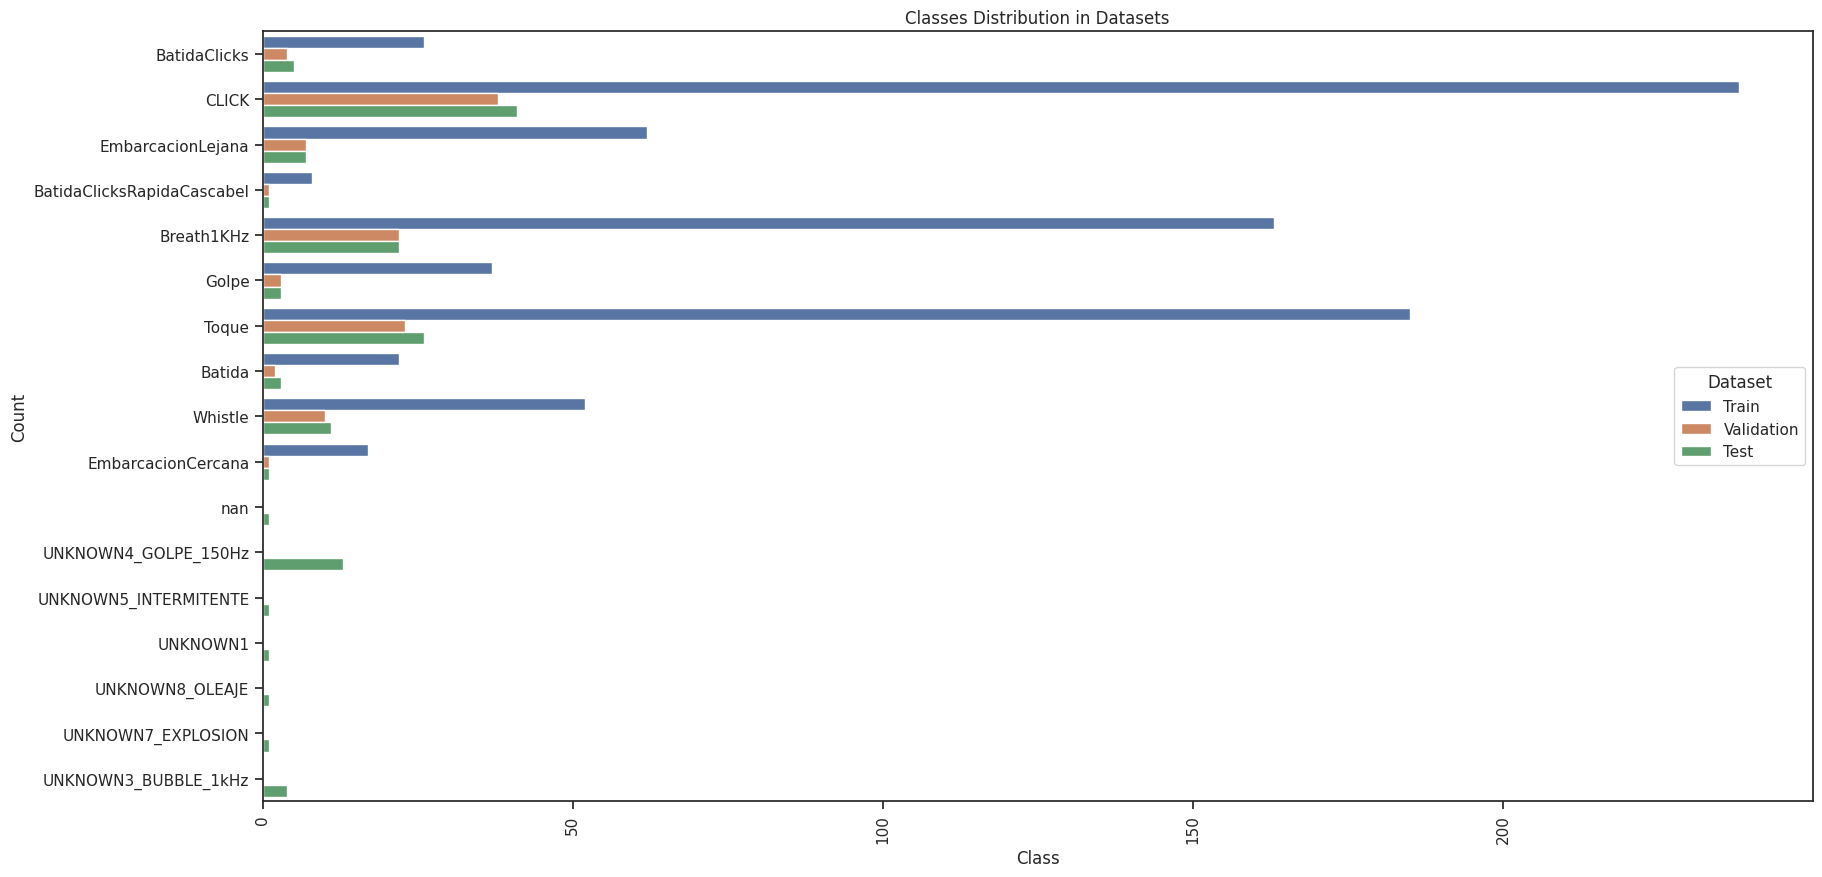

In [5]:
# Bar plot of dataset count
plt.figure(figsize=(20, 10))
sns.barplot(y='Class', x='Count', hue='Dataset', data=combined_dist)
plt.title('Classes Distribution in Datasets')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Dataset', loc="right")
plt.show()

In [6]:
pd.set_option('display.max_colwidth', None)
# See only columns with negative duration
combined_csv[combined_csv["Duration"] < 0][["OriginalAudioPath", "StartSecond", "EndSecond", "Duration", "Class", "Dataset"]]

,OriginalAudioPath,StartSecond,EndSecond,Duration,Class,Dataset


/tmp/ipykernel_126979/4238244335.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Conjunto de Datos')


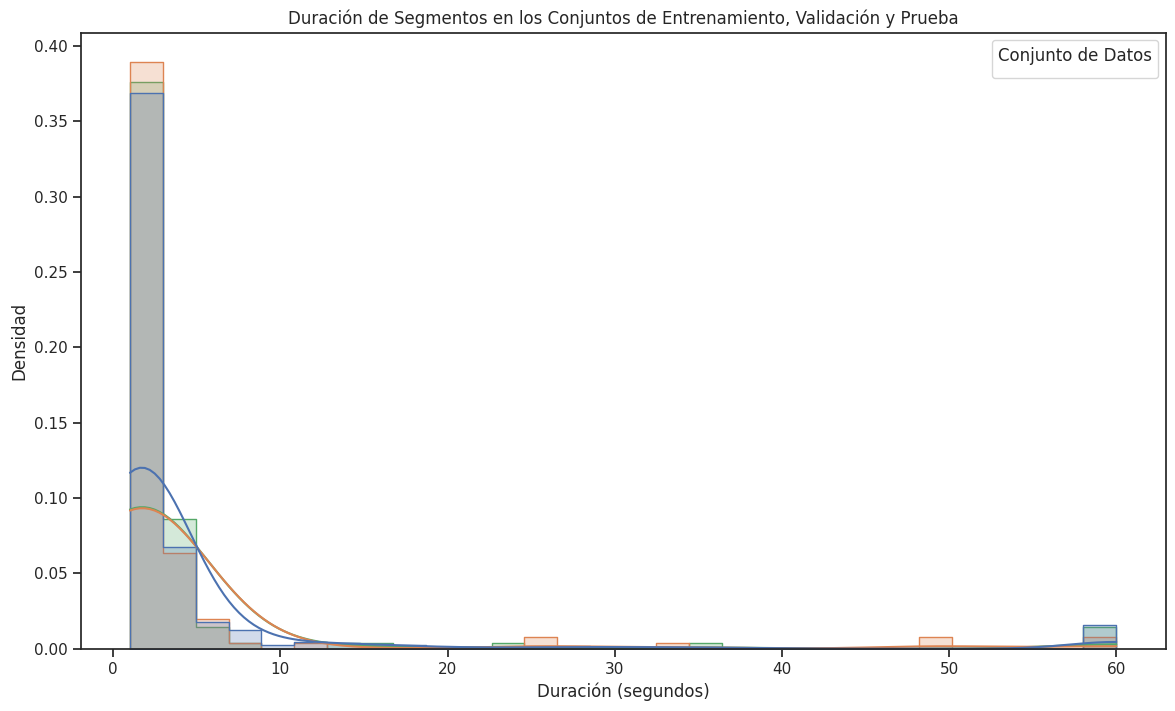

In [7]:
# Crear el gráfico de duración de audios
plt.figure(figsize=(14, 8))
sns.histplot(data=combined_csv, x='Duration', hue='Dataset', element='step', stat='density', common_norm=False, bins=30, kde=True)
plt.title('Duración de Segmentos en los Conjuntos de Entrenamiento, Validación y Prueba')
plt.xlabel('Duración (segundos)')
plt.ylabel('Densidad')
plt.legend(title='Conjunto de Datos')
plt.show()

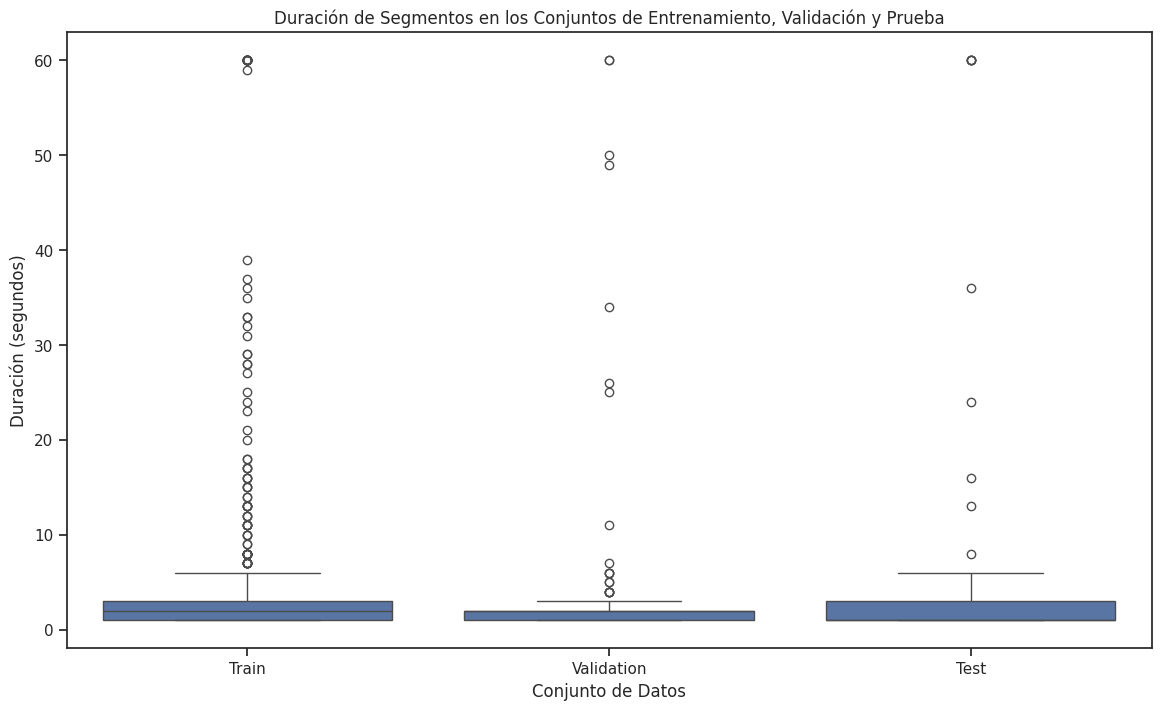

In [8]:
# Crear el gráfico de caja (boxplot)
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_csv, x='Dataset', y='Duration')
plt.title('Duración de Segmentos en los Conjuntos de Entrenamiento, Validación y Prueba')
plt.xlabel('Conjunto de Datos')
plt.ylabel('Duración (segundos)')
plt.show()

In [9]:
# prijt number of audios with more than 3 seconds duration, 3 seconds duration and less than 3 seconds duration
print(f"Number of audios with less than 3 seconds duration: {len(combined_csv[combined_csv['Duration'] < 3])}")
print(f"Number of audios with 3 seconds duration: {len(combined_csv[combined_csv['Duration'] == 3])}")
print(f"Number of audios with more than 3 seconds duration: {len(combined_csv[combined_csv['Duration'] > 3])}")

Number of audios with less than 3 seconds duration: 892
Number of audios with 3 seconds duration: 112
Number of audios with more than 3 seconds duration: 216


/tmp/ipykernel_126979/639803445.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Conjunto de Datos')


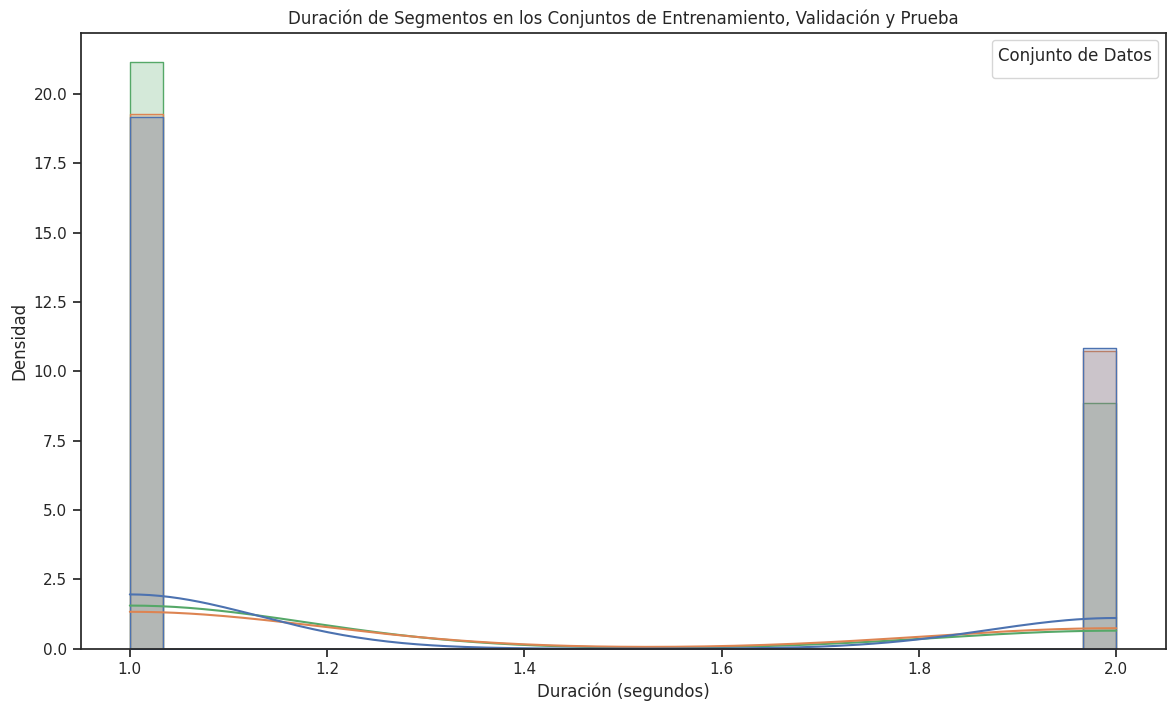

In [10]:
# Crear el gráfico de duración de audios
plt.figure(figsize=(14, 8))
sns.histplot(data=combined_csv[combined_csv['Duration'] < 3], x='Duration', hue='Dataset', element='step', stat='density', common_norm=False, bins=30, kde=True)
plt.title('Duración de Segmentos en los Conjuntos de Entrenamiento, Validación y Prueba')
plt.xlabel('Duración (segundos)')
plt.ylabel('Densidad')
plt.legend(title='Conjunto de Datos')
plt.show()

# Preprocess Audios

As most audios are 3 seconds more or less, the time windows that will be used will be 3 seconds

Sampling rate was 256000 but BirdNET takes 32000, so 32000 will be used.

Class: BatidaClicks


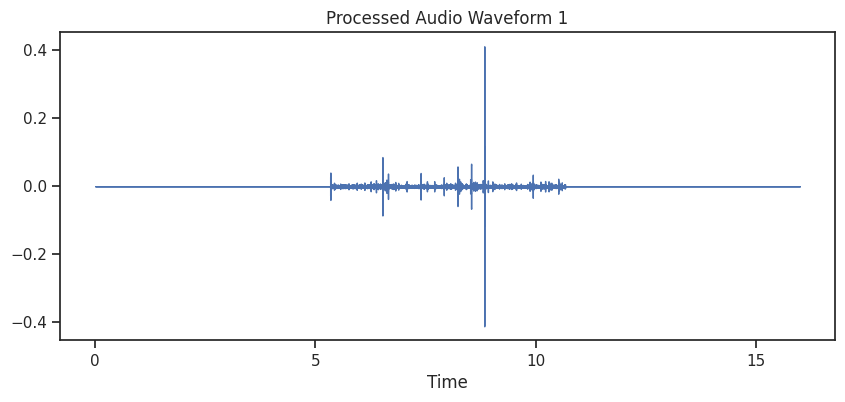

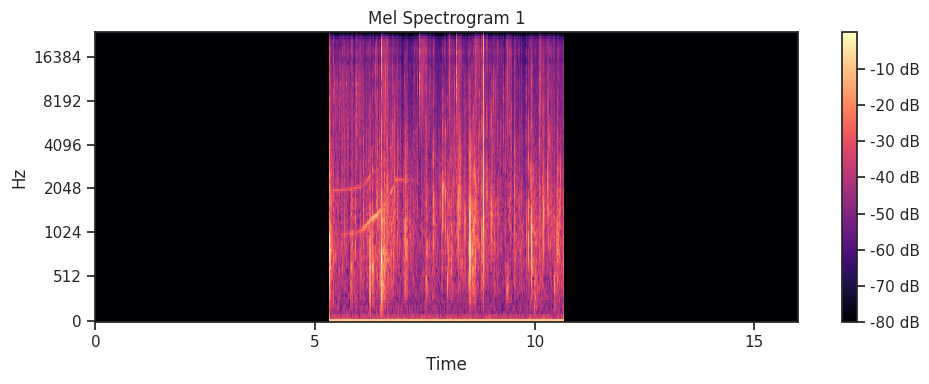

In [11]:
# Function to preprocess audio
def preprocess_audio(file_path, target_sr=48000, duration=3):
    # Load audio
    signal, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
    # Calculate the maximum length in samples
    max_length = target_sr * duration  # e.g., 48000 * 3
    
    # If the signal is shorter than the desired length, pad with silence
    if len(signal) < max_length:
        padding = max_length - len(signal)
        pad_left = padding // 2
        pad_right = padding - pad_left
        signal = np.pad(signal, (pad_left, pad_right), mode='constant')
        return [signal]
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(signal) > max_length:
        segments = []
        for start in range(0, len(signal), max_length):
            end = start + max_length
            segment = signal[start:end]
            if len(segment) < max_length:
                segment = np.pad(segment, (0, max_length - len(segment)), mode='constant')
            segments.append(segment)
        return segments
    
    # If the signal is exactly the desired length, return as is
    else:
        return [signal]

# Test preprocess on a single file
sample_file = os.path.join(train_folder, train_classes[0], os.listdir(os.path.join(train_folder, train_classes[0]))[0])
processed_audios = preprocess_audio(sample_file, target_sr=256000, duration=3)

# Visualize waveforms

# print class
print(f"Class: {train_classes[0]}")

for i, processed_audio in enumerate(processed_audios):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(processed_audio, sr=48000)
    plt.title(f"Processed Audio Waveform {i+1}")
    plt.show()
    
    # Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=processed_audio, sr=48000)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Visualize mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram {i+1}")
    plt.tight_layout()
    plt.show()

In [12]:
# delete classes that contains Unknown or nan
classes.remove("UNKNOWN5_INTERMITENTE")
classes.remove("nan")
classes.remove("UNKNOWN8_OLEAJE")
classes.remove("UNKNOWN1")
classes.remove("UNKNOWN3_BUBBLE_1kHz")
classes.remove("UNKNOWN4_GOLPE_150Hz")
classes.remove("UNKNOWN7_EXPLOSION")

In [13]:
classes

['Golpe',
 'Toque',
 'Whistle',
 'Breath1KHz',
 'Batida',
 'EmbarcacionLejana',
 'EmbarcacionCercana',
 'CLICK',
 'BatidaClicksRapidaCascabel',
 'BatidaClicks']

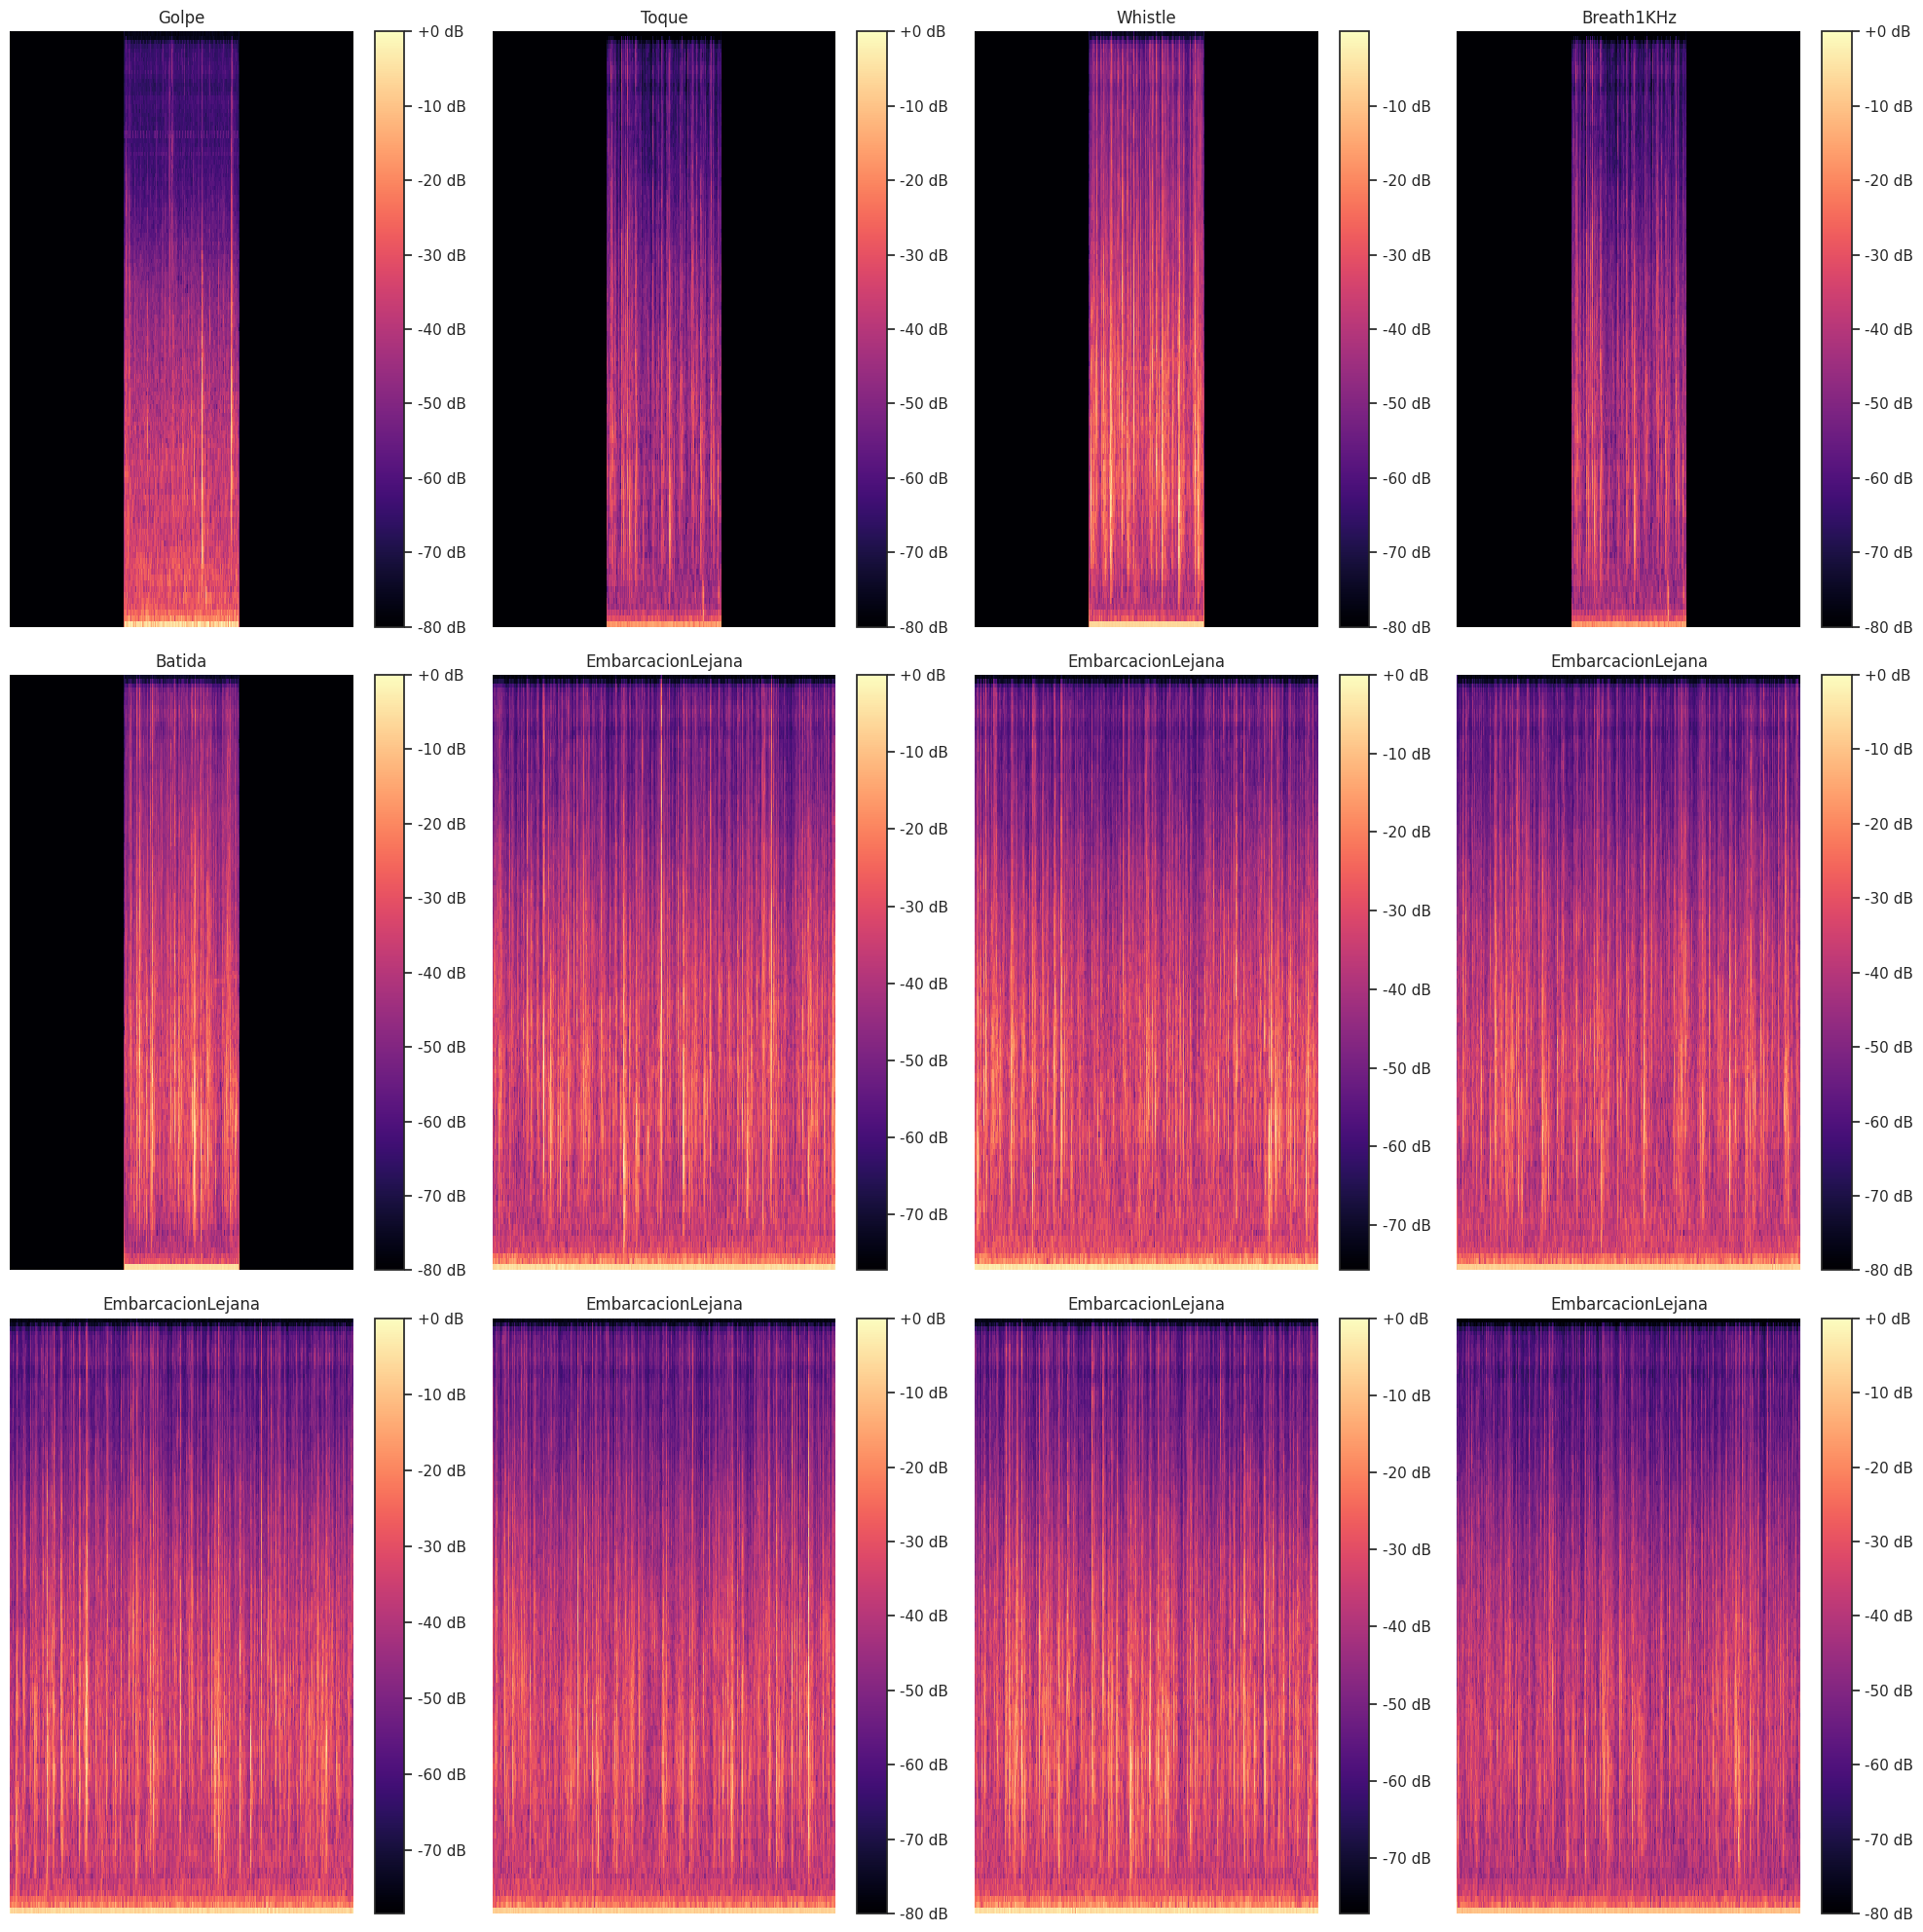

In [14]:
# take 1 random sample per class
samples = []
sample_classes = []
for cls in classes:
    if cls in train_classes:
        sample_file = os.path.join(train_folder, cls, os.listdir(os.path.join(train_folder, cls))[0])
        processed_audios = preprocess_audio(sample_file, target_sr=256000, duration=3)
        samples.extend(processed_audios)
        sample_classes.extend([cls] * len(processed_audios))

# Show a 5x5 grid of sample audios
plt.figure(figsize=(20, 20))
for i in range(3):
    for j in range(4):
        idx = i * 4 + j
        plt.subplot(3, 4, idx + 1)

        mel_spectrogram = librosa.feature.melspectrogram(y=samples[idx], sr=48000)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.title(sample_classes[idx])
        plt.axis('off')
plt.tight_layout()

# Data Generators

In [15]:
def audio_data_generator(folder, classes, batch_size=32, target_sr=48000, duration=3):
    while True:
        X, y = [], []
        for cls_index, cls_name in enumerate(classes):
            cls_folder = os.path.join(folder, cls_name)
            files = os.listdir(cls_folder)
            
            for file in files:
                file_path = os.path.join(cls_folder, file)
                signals = preprocess_audio(file_path, target_sr, duration)
                for signal in signals:
                    X.append(signal)
                    y.append(cls_index)
                    
                    if len(X) == batch_size:
                        X = np.array(X)
                        y = np.array(y)
                        yield X, to_categorical(y, num_classes=len(classes))
                        X, y = [], []

# Test the generator
gen = audio_data_generator(train_folder, train_classes, batch_size=8)
X_batch, y_batch = next(gen)

print(f"Batch Shape: {X_batch.shape}")
print(f"Labels Shape: {y_batch.shape}")


Batch Shape: (8, 144000)
Labels Shape: (8, 10)


# Model

In [16]:
# Load the model
model_path = 'BirdNET-Analyzer-V2.4/V2.4/BirdNET_GLOBAL_6K_V2.4_Model/'
model = tf.keras.models.load_model(model_path, compile=False).model

In [17]:
# Modify the model for your number of classes
output_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(model.output)

model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 MEL_SPEC1 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                                  
 MEL_SPEC2 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                              

                                                                                                  
 ACT_0 (Activation)          (None, 48, 256, 24)          0         ['BNORM_0[1][0]']             
                                                                                                  
 POOL_0_MAX (MaxPooling2D)   (None, 48, 128, 24)          0         ['ACT_0[1][0]']               
                                                                                                  
 POOL_0_AVG (AveragePooling  (None, 48, 128, 24)          0         ['ACT_0[1][0]']               
 2D)                                                                                              
                                                                                                  
 POOL_0_CONCAT (Concatenate  (None, 48, 128, 48)          0         ['POOL_0_MAX[1][0]',          
 )                                                                   'POOL_0_AVG[1][0]']          
          

In [18]:
# not common classes
not_common_classes = set(train_classes) - set(validation_classes)
print(f"Not common classes: {not_common_classes}")

Not common classes: set()


Unknown classes are not balanced, so they will be taken out

# Train Model

In [19]:
BATCH_SIZE = 8

In [20]:
# Ensure required libraries are imported
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1),
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1),
    CSVLogger("training_log.csv", append=True)
]

# Training and Validation Generators
train_gen = audio_data_generator(train_folder, train_classes, batch_size=BATCH_SIZE)
val_gen = audio_data_generator(validation_folder, validation_classes, batch_size=BATCH_SIZE)

# Calculate steps per epoch and validation steps
def calculate_steps(folder, classes, batch_size):
    total_samples = sum(len(os.listdir(os.path.join(folder, cls))) for cls in classes)
    return total_samples // batch_size

steps_per_epoch = calculate_steps(train_folder, train_classes, BATCH_SIZE)
validation_steps = calculate_steps(validation_folder, validation_classes, BATCH_SIZE)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 37.3181 - accuracy: 0.8453
Epoch 1: val_accuracy improved from -inf to 0.57692, saving model to best_model.h5


/home/gruncrow/anaconda3/envs/BirdNET/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 81s 673ms/step - loss: 37.3181 - accuracy: 0.8453 - val_loss: 471.5972 - val_accuracy: 0.5769
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 54.1761 - accuracy: 0.6696
Epoch 2: val_accuracy did not improve from 0.57692
101/101 [==============================] - 62s 614ms/step - loss: 54.1761 - accuracy: 0.6696 - val_loss: 504.7297 - val_accuracy: 0.2692
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 8.6686 - accuracy: 0.4295
Epoch 3: val_accuracy improved from 0.57692 to 0.87500, saving model to best_model.h5
101/101 [==============================] - 60s 598ms/step - loss: 8.6686 - accuracy: 0.4295 - val_loss: 1.7628 - val_accuracy: 0.8750
Epoch 4/50
101/101 [==============================] - ETA: 0s - loss: 1.7813 - accuracy: 0.5854
Epoch 4: val_accuracy did not improve from 0.87500
101/101 [==============================] - 62s 616ms/step - loss: 1.7813 - accuracy: 0.5854 - val_loss: 21.7728 - v

# Monitor Training

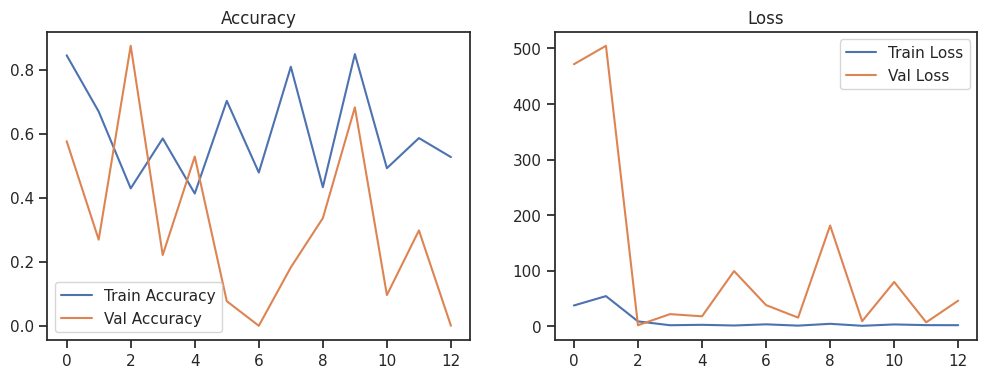

In [21]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

# Evaluate Model

In [ ]:
# Evaluate on test data
test_gen = audio_data_generator(test_folder, test_classes, batch_size=32)
test_steps = sum(len(os.listdir(os.path.join(test_folder, cls))) for cls in test_classes) // 32

results = model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")


3/3 [==============================] - 2s 541ms/step - loss: 6.3560 - accuracy: 0.5000
Test Loss: 6.3560404777526855, Test Accuracy: 0.5


: 